<a href="https://colab.research.google.com/github/rogerwzeng/e17/blob/main/09_Kalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filter Tutorial

This tutorial will explore topics in SLAM (Simultaneous Localization & Mapping) with the Kalman Filter.

## Context

We will explore SLAM with the Kalman Filter for 2D Robot motion (i.e., a robot moving in 2 dimensions). Common situations that can be modeled as 2D Robot motion include robots navigating a warehouse, an autonomous vehicle navigating the streets, or a drone navigating at a constant elevation.

Let’s work in the setting where the robot is traveling at a constant speed. We can model the system dynamics as Newtonian motion. The key equations describing motion from physics are:

\begin{align}
v &= v_0 + at \\
x &= x_0 + v_0t + 0.5at^2
\end{align}

where:
- $t$: time
- $a$: acceleration
- $v$: velocity
- $v_0$: velocity at time $t = 0$
- $x$: position
- $x_0$: position at time $t = 0$

Since our robot is at constant speed, the acceleration term is zero, so our equations simplify to:

\begin{align}
v &= v_0 \\
x &= x_0 + v_0 t
\end{align}


Let’s also work in the setting where we have access to a GPS sensor that can provide measurements on the position of the robot.

Using the state dynamics as described by Newtonian motion and measurements from our sensors, we want to effectively combine them to accurate estimate the state of our robot. To achieve this, we’ll use the Kalman Filter.

## Kalman Filter

The Kalman filter is an iterative process where we make predictions of the state, collect measurements, and update our estimate based on our confidence of the prediction and measurements. More formally, the Kalman filter is described by the following:

Prediction:
\begin{align}
\mathbf{\bar{x}} &= \mathbf{Fx} + \mathbf{Bu} \\
\mathbf{\bar{P}} &= \mathbf{FPF}^T + \mathbf{Q}
\end{align}

Update:
\begin{align}
\mathbf{y} &= \mathbf{z} - \mathbf{H\bar{x}}\\
\mathbf{S} &= \mathbf{H}\mathbf{\bar{P}}\mathbf{H}^T+\mathbf{R}\\
\mathbf{K} &= \mathbf{\bar{P}H}^T\mathbf{S}^{-1}\\
\mathbf{x} &= \mathbf{\bar{x}} + \mathbf{Ky}\\
\mathbf{P} &= (\mathbf{I} - \mathbf{KH})\mathbf{\bar{P}}\\
\end{align}

where:
- $\textbf{x}$: state
- $\textbf{P}$: state noise
- $\bar{\textbf{x}}$: prediction
- $\bar{\textbf{P}}$: prediction noise
- $\textbf{F}$: state transition function
- $\textbf{Q}$: process noise
- $\textbf{B}$: control function
- $\textbf{u}$: control input
- $\textbf{z}$: measurement
- $\textbf{H}$: measurement function
- $\textbf{R}$: measurement noise
- $\textbf{y}$: residual
- $\textbf{S}$: system / residual uncertainity
- $\textbf{K}$: kalman gain
- $\textbf{I}$: identity matrix


To use the Kalman Filter, we need to explicitly design and define the vectors and matrices. Properly selecting what values the components of the Kalman filter should take **is not trivial** - often it can be very difficult to select the appropriate values and involves leveraging ideas from various engineering domains as well as iterating / fine tuning. It’s important to select the right values for the Kalman filter to ensure it estimates correctly because the Kalman filter can confidently converge on the wrong values (i.e., be a smug filter).

### State: $\mathbf{x}$

We need to define our state variables. The Kalman filter will track and update the state variables. In the Kalman filter equations, the state variables are encapsulated by the $\mathbf{x}$ vectors.

In theory, we can have as few (at least one) or as many state variables as desirable. If we have too few state variables, we won’t properly describe our system. If we have too many state variables, it can be too complex or unyielding to properly encapsulate the system. Furthermore, when there are too many state variables, it can become computational unstable and / or infeasible. Beyond the number of state variables, we also want to select the **right** state variables, meaning that we can reasonable model and measure them. Understanding the system process and available sensors / measurements can inform thoughtful design of the state space.

We're tracking robot motion in 2 dimensions described by Newtonian motion under constant speed and have a GPS sensor available that provides measurements on location. Thus, for this system, an appropraite set of state variables are:
- $x$: x-coordinate position
- $y$: y-coordinate position
- $v_x$: velocity in the x-direction
- $y_x$: velocity in the y-direction



As an aside, there are alternative sets of state variables we can use.

For example, we can consider the set of state variables that are the just the position (so $x$ and $y$ only). Since we're tracking for the location of the robot, the velocity may not be significantly relevant. Furthermore, we don't have any sensors that measure velocity so including them may result in extra noise.

Another alternative is to add more state variables, such as acceleration or jerk. Perhaps the more information we track at a time, the better our filter will estimate the robot. However, for this example, we don't have sensors measuring these additional state variables which may actually degrade the performance of our filter.

In practice, we'd design multiple Kalman filters with different sets of state variables and evaluate which produces the best results.

In terms of implementation, we can express our state variables in any order for the state vector. For example, here are two possible conventions for our state vector using our state variables.

$$
\begin{bmatrix}
x\\y\\v_x\\v_y
\end{bmatrix} \text{ or } \begin{bmatrix}
x\\v_x\\y\\v_y
\end{bmatrix}
$$

We'll get the same results using either as long as we are consistent about which order / orientation throughout the entire Kalman Filter. Typically, it make senses to have the order the state variables by some group.

Also, notice that the vectors above are column vectors (i.e., they are tall / skinny with width 1). In many engineering and computer science domains, we typically represent and conceptualize vectors as column vectors. However, using column vectors for communication or in writing can be cumbersome so instead we represent them as the transpose of row vectors. In layman's term, row vectors are wide and have height 1 (i.e., you can think of it as a column vector flipped on its side). The transpose of a vector is that vector flipped on its side, so when you have a transpose of a row vector, it's represents a column vector.

For our Kalman filter example, our state vector will be oriented as:

$$
\mathbf{x} = \begin{bmatrix}
x\\v_x\\y\\v_y
\end{bmatrix}
$$

We can also express our state vector as a row vector: $[x, v_x, y, v_y]^T$. Moving forward, we'll be expressing vectors in row-vector form.

### State Noise: $\mathbf{P}$

The state noise matrix $\mathbf{P}$ expresses our confidence in our state vector $\mathbf{x}$. It captures the noise / variance for each state variable along the diagonal values and the covariances between states on the off-diagonal values. Similar to our state vector $\mathbf{x}$, the Kalman filter tracks and updates the state noise matrix $\mathbf{P}$. The ideal behavior is for the values in state noise matrix $\mathbf{P}$ to reduce as we get more confident in our state estimates. The shape of the state noise matrix $\mathbf{P}$ is $(|\mathbf{x}|, |\mathbf{x}|)$ where $|\mathbf{x}|$ is the number of states and the order of the rows (top to bottom) and columns (left to right) should match the order of the state vector $\mathbf{x}$.

Given our state vector $\mathbf{x} = [x, v_x, y, v_y]^T$, our state noise matrix $\mathbf{P}$ would look like:


$$
\mathbf{P} = \begin{bmatrix}
\sigma^2_{x} & \sigma^2_{x,v_x} & \sigma^2_{x,y} & \sigma^2_{x,v_y} \\
\sigma^2_{v_x,x} & \sigma^2_{v_x} & \sigma^2_{v_x,y} & \sigma^2_{v_x,v_y} \\
\sigma^2_{y,x} & \sigma^2_{y,v_x} & \sigma^2_{y} & \sigma^2_{y,v_y}  \\
\sigma^2_{v_y,x} & \sigma^2_{v_y,v_x} & \sigma^2_{v_y,y} & \sigma^2_{v_y} \\
\end{bmatrix}
$$


Note that this matrix is symmetric (along the diagonal) as $\sigma^2_{a,b}$ = $\sigma^2_{b,a}$.

### Prediciton: $\bar{\textbf{x}}$

The Kalman filter makes prediction for the state, $\mathbf{\bar{x}}$, using information about the previous values for the state, the state transition function, $\mathbf{F}$, and the control function, $\mathbf{B}$, and input, $\mathbf{u}$. The shape for the prediction and order for the values is the same as our state vector $\mathbf{x} = [x, v_x, y, v_y]^T$. For the Kalman filter, the prediction, $\mathbf{\bar{x}}$, is calculated as part of the process and we don't need to provide it as input.

For our system, the prediction, $\mathbf{\bar{x}}$, will predict our new $x$ position, new $y$ position, new velocity in the $x$ direction, and new velocity in the $y$ direction.

### Prediciton Noise: $\bar{\textbf{P}}$

When we make a prediction, $\mathbf{\bar{x}}$, we also need the noise associated with it. To do this, we adjust our previous state noise by scaling with it the state transition function (hence the term $\mathbf{FPF}^T$) and adding the process noise ($\mathbf{Q}$) which can be viewed as the noise associated with our state transition function. The prediction noise $\mathbf{\bar{P}}$ tells us how confident we should be with the prediction. The shape of prediction noise $\mathbf{\bar{P}}$ is the same as $\mathbf{P}$. For the Kalman filter, the prediction noise, $\mathbf{\bar{P}}$, is calculated as part of the process and we don't need to provide it as input.

For our system, the prediction noise $\mathbf{\bar{P}}$ informs us of how confident we are about the predicted $x$ position, $y$ position, velocity in the $x$ direction, and velocity in the $y$ direction are.

### State Transition Function: $\mathbf{F}$

The state transition function is a matrix that describes how we transition from states at time step $t$ to time step $t+1$. It used to make predictions. An assumption baked in the Kalman filter is that the states at time $t+1$ is linear function of the states at time $t$.

Determining the state transition function $\mathbf{F}$ requires understanding and modeling the system dyanmics. In our situation, we're using Newtonian motion so we already have a model to describe the robot. We'd use the equations for Newtonian motion under a constant speed to design our state transition function $\mathbf{F}$. We need re-express those equations in terms of time steps.

For modeling simplicity, we'll assume the motion along the x and y direction are independent. Using the Newtonian equations under a constant speed, we get:

\begin{align}
x_t &= x_{t-1} + v_{x,t-1}\Delta t  \\
v_{x,t} &= v_{x,t-1} \\
y_t &= y_{t-1} + v_{y,t-1}\Delta t  \\
v_{y,t} &= v_{y,t-1} \\
\end{align}

Making sense of the above:
- the Newtonian dynamics told us that the position at the next time step is the position at the current time step plus the amount that we'll travel, which determined by speed multiplied by the time traveled (e.g., imagine your speed is 4 m/s and you traveled for 2 seconds, then the total amount you traveled is 8 meters so your next position is your old position plus 8 meters)
- the Newtonian dynamics told us that the velocity doesn't change so the velocity at the next time step is the velocity at the current time step

Now we'll use the above equations to design the state transition function $\mathbf{F}$ which will have shape $(|\mathbf{x}|, |\mathbf{x}|)$ where $|\mathbf{x}|$ is the number of states. Recall we defined the state vector as $\mathbf{x} = [x, v_x, y, v_y]^T$, so our the columns (from left to right) and rows (from top to bottom) for matrix $\mathbf{F}$ will be in that order. One intrepretation of the matrix $\mathbf{F}$ is that it describes the linear function between states at time $t$ to time $t+1$, so for explicit demonstrative purposes, let's re-express the above equations in terms of the full state space with coefficients in front, bolded in the order of state variables in $\mathbf{x}$:

\begin{align}
x_t &= \mathbf{1} x_{t-1} + \mathbf{\Delta t} v_{x,t-1} + \mathbf{0} y_{t-1} + \mathbf{0} v_{y,t-1} \\
v_{x,t} &= \mathbf{0} x_{t-1} + \mathbf{1}v_{x,t-1} + \mathbf{0} y_{t-1} + \mathbf{0} v_{y,t-1} \\
y_t &= \mathbf{0} x_{t-1} + \mathbf{0} v_{x,t-1} + \mathbf{1}y_{t-1} + \mathbf{\Delta t} v_{y,t-1} \\
v_{y,t} &= \mathbf{0} x_{t-1} + \mathbf{0} v_{x,t-1} + \mathbf{0} y_{t-1} + \mathbf{1} v_{y,t-1} \\
\end{align}

Thus, our state transition function matrix $\mathbf{F}$ is:

$$
\mathbf{F} = \begin{bmatrix}
1 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \Delta t  \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

Notice that the matrix $\mathbf{F}$ has a $\Delta t$. For our example, $\Delta t = 1$, meaning we predict every second but we can also predict at different intervals (hence why we have $\Delta t$ instead of a number).

### Process Noise: $\mathbf{Q}$

The process noise describes our uncertainity with our process model - in this case, with the dynamics of the Newtonian motion under a constant speed. Designing an appropraite process noise matrix $\mathbf{Q}$ is difficult. It often requires domain expertise or doing experiments to collect data to estimate a reasonable process noise. The shape of the process noise matrix $\mathbf{Q}$ is $(|\mathbf{x}|, |\mathbf{x}|)$ where $|\mathbf{x}|$ is the number of states and the order of the rows and columns follow the order of the state vector $\mathbf{x}$.

For the sake of simplicity, we'll use a discrete time Wiener process, which is a type of constant noise, to describe the process noise. There are other alternatives such as the Singer model. For those curious on alternative ways to describe the process noise, [please read here](https://apps.dtic.mil/sti/pdfs/AD1103353.pdf).

As stated in the state transtion function section, we're assuming that motion in the x and y direction are indepedent, thus the covariance between the x and y state variables should be zero. Our process noise matrix $\mathbf{Q}$ will be:

$$
\mathbf{Q} = \begin{bmatrix}
0 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
0 & 0 & 0 & 1  \\
0 & 0 & 1 & 1 \\
\end{bmatrix} \sigma_q^2
$$

The $\sigma_q^2$ is a tunable parameter that describes the variance of the constant white noise. The less confident we are in our process model / state transitions, the larger $\sigma_q^2$ should be. We can experiement with the value of $\sigma_q^2$ for the optimal Kalman filter performance. For this example, we'll set $\sigma_q^2 = 0.005$.

### Control Function and Control Input: $\mathbf{B}$, $\mathbf{u}$

In situations where the robot has input (i.e., someone is controlling the robot), we’d have a control function $\mathbf{B}$ and control input $\mathbf{u}$. The control input, $\mathbf{u}$, refers to the commands or directives. The control function, $\mathbf{B}$, maps the input to the state space. The control input $\mathbf{u}$ will be a column vector. The control function $\mathbf{B}$ will be shape $(|\mathbf{x}|, |\mathbf{u}|)$ where $|\mathbf{x}|$ is the number of states (rows) and $|\mathbf{u}|$ is the number of inputs (columns).

We need a control function, $\mathbf{B}$, as inputs might not directly correspond with the states. For example, the number of inputs maybe different than the number of states - thus the control function, $\mathbf{B}$, ensures proper matrix shape for the Kalman filter. Moreover, a combination of inputs might affect our states - the control function, $\mathbf{B}$, can capture how to properly combine the inputs.

Consider our current robot tracking situation. We could potentially have inputs for steering (i.e., four values corresponding to left, right, forward, and backward) which is captured by the control input $\mathbf{u}$. The steering input could affect the position and velocity in different ways, so we need a control function, $\mathbf{B}$, to transform the inputs to work in the state space. To appropraitely design $\mathbf{u}$ and $\mathbf{B}$, we need to consider how the robot inputs work and how they map to the states.

For the sake of simplicity, we will assume there is no control input. Thus, the values for $\mathbf{u}$ and $\mathbf{B}$ will be the zero vector and zero matrix.




### Measurement: $\mathbf{z}$

The measurement vector $\mathbf{z}$ refers to the measurements. The measurements play a key role in the Kalman filter update step. It is combined with prediction state $\mathbf{\bar{x}}$ to form our new estimate. Furthermore, we can use the first measurement to inform the initial state $\mathbf{x}$.

In terms of dimensions, the number of values in $\mathbf{z}$ will correspond to the number of measurements we collect, which may not necessarily be equal to the number of states. The number of measurements available will be based on the sensors we include / use. Furthermore, the measurements may not share the same units or directly correspond to the states, which why we need a measurement function $\mathbf{H}$ takes our states and translates them into the measurement space.

For our situatuon, we have a GPS which will provide two measurements, the $x$ position, which we will denote as $z_x$, and the $y$ position, which we will denote as $z_y$. We will express the measurement vector in that order:

$$
\mathbf{z} = \begin{bmatrix}
z_x\\z_y
\end{bmatrix}
$$

Note: the particular order of the measurements doesn't matter as long as we are consistent through out.

### Measurement Function: $\mathbf{H}$

Often, our measurements and states might be different spaces. This can happen when:
- the units differ between the measurements and states
- there are a different number of measurements and states
- the measurements are a function of the states

The measurement function $\mathbf{H}$ takes our states and translates them into the measurement space. In designing the matrix $\mathbf{H}$, we need to consider what measurements we have, what their units are, and how they relate to the states. To make sure the math works, the dimension of our matrix $\mathbf{H}$ should be $(|\mathbf{z}|, |\mathbf{x}|)$ where $|\mathbf{z}|$ is the number of measurements in the proper order (rows) and $|\mathbf{x}|$ is the number of states in the proper order (columns).

In our situation, we only have a GPS sensor that gives us position data on $x$ and $y$. Let's also say that this GPS sensor provides us measurements in feet but our states are in meters. The conversion is 1 meter is roughly 3.3 feet. Thus, our measurement function $\mathbf{H}$ is:

$$
\mathbf{H} = \begin{bmatrix}
3.3 & 0 & 0 & 0 \\
0 & 0 & 3.3 & 0 \\
\end{bmatrix}
$$

The order of the rows, from top to bottom, of the measurement function $\mathbf{H}$ is the measurement for $x$, $z_x$, and the measurement for $y$, $z_y$. The order of the columns, from left to right, correspond to the state vector as $\mathbf{x} = [x, v_x, y, v_y]^T$. The matrix has zero values for where the states don't relate to or have any measurements.

The measurement function $\mathbf{H}$ converts our states into the measurement space so we can accurate relate them. The measurement function $\mathbf{H}$ also ensures the proper shape in our operations, such as when calculating the residuals $\mathbf{y}$, where we are subtracting the measurements from the predicted states.


### Measurement Noise: $\mathbf{R}$

The measurement noise matrix $\mathbf{R}$ captures our confidence in the measurements / sensors. The diagonal values represent the variance in the individual measurements / sensors and the off-diagonal values represent the covariance between the measurements / sensors. The shape of the measurement noise matrix $\mathbf{R}$ is $(|\mathbf{z}|, |\mathbf{z}|)$ where $|\mathbf{z}|$ is the number of measurements and the order of the rows and columns follow the order of the measurement vector $\mathbf{z}$.

There are several ways to determine the values for the measurement noise matrix $\mathbf{R}$:
- use the specifications on the sensors which will typically include metrics on how reliable / noisy the sensors are
- collect measurement data for the situation and empiricial calculate the covariance matrix
- make modeling assumptions based on knowledge of the system

For our situation, we have GPS sensor that provides a measurement for the $x$ and $y$ position, $z_x$ and $z_y$. The specifications on the GPS sensor informs us the measurement noise follows $ \mathcal{N}(0, 2)$. As for the covariances, we'll stick with our assumption that the motion in the $x$ and $y$ directions are independent, thus they would be zero. Therefore:

$$
\mathbf{R} = \begin{bmatrix}
2 & 0  \\
0 & 2  \\
\end{bmatrix}
$$

Alternatively, we could have collected data using this GPS sensor and then calculated an empirical covariance matrix to use.

### Residual: $\mathbf{y}$

The residual is the difference between our measurement and prediction. We use the residual, $\mathbf{y}$, to adjust the prediction, $\mathbf{\bar{x}}$, to form our state estimate. The importance of the residual, $\mathbf{y}$, is described by the Kalman Gain, $\mathbf{K}$, which encapsulates information about how confident we are about our prediction and measurement. If we're more confident on the prediction, our residual will have a small impact on the estimate. If we're more confident on the measurement, our residual will have a larger impact on the estimate.

By the definition of residual, the shape of the residual, $\mathbf{y}$, should be the same as the shape of our measurement vector, $\mathbf{z}$, because we want the difference between our measurement and prediction. Our measurement might be in one space and our states might be another, hence why we have the measurement function $\mathbf{H}$ in the residual formulation to convert the state into the measurement space.

For our situation, our residual, $\mathbf{y}$, will be:

$$
\mathbf{y} = \begin{bmatrix}
y_x\\y_y
\end{bmatrix}
$$

where:
- $y_x$: the residual between the measurement and prediction for the $x$ position
- $y_y$: the residual between the measurement and prediction for the $y$ position

Notice that our residual vector doesn't have components for the velocity in the $x$ and $y$ direction because we have no measurements for them and can't calculate residuals. This is expressed in the measurement function $\mathbf{H}$ where the entries corresponding to those state variabeles are zero.


### System Uncertainity: $\mathbf{S}$

The system uncertainity $\mathbf{S}$ describes the noise surrounding the residual. Since the residual formulation is a combination of the prediction and measurement, the system uncertainity is the combination of the prediction noise and measurement noise. Since the space of the prediction and measurement are different, we need to transform the prediction noise with measurement function (hence the $\mathbf{H}\mathbf{\bar{P}}\mathbf{H}^T$ term). After transforming the prediction noise, we add in the measurement noise ($\mathbf{R}$). The shape of the system uncertainity $\mathbf{S}$ is $(|\mathbf{z}|, |\mathbf{z}|)$ where $|\mathbf{z}|$ is the number of measurements and the order of the rows and columns follow the order of the measurement vector $\mathbf{z}$.

The system uncertainity $\mathbf{S}$ is calculated as part of the Kalman filter and used for determining the Kalman Gain, which is used to weigh the predictions and measurements in determining the state estimate.

For our situation, the system uncertainity $\mathbf{S}$ will be:

$$
\mathbf{S} = \begin{bmatrix}
\sigma^2_{y_x} & \sigma^2_{y_x,y_y}  \\
\sigma^2_{y_y,y_x} & \sigma^2_{y_y}  \\
\end{bmatrix}
$$

Note that this matrix is symmetric (along the diagonal) as $\sigma^2_{a,b}$ = $\sigma^2_{b,a}$.

### Kalman Gain: $\mathbf{K}$

The Kalman Gain $\mathbf{K}$ describes we should treat information about the residual in our state estimate. It encapsulates information about how confident we are about our prediction and measurement. If we're more confident on the prediction, the Kalman Gain $\mathbf{K}$ will reduce the impact / magnitude of the values of the residual. If we're more confident on the measurement, the Kalman Gain $\mathbf{K}$ will increase the impact / magnitude of the values of the residual. The shape of the Kalman Gain $\mathbf{K}$ will be $(|\mathbf{x}|, |\mathbf{z}|)$ where $|\mathbf{x}|$ is the number of states in the proper order (rows) and $|\mathbf{z}|$ is the number of measurements in the proper order (columns).

For our situation, the Kalman Gain $\mathbf{K}$ will be:

$$
\mathbf{K} = \begin{bmatrix}
k_{y_x,x} & k_{y_y,x}  \\
k_{y_x,v_x} & k_{y_y,v_x}  \\
k_{y_x,y} & k_{y_y,y}  \\
k_{y_x,v_y} & k_{y_y,v_y}  \\
\end{bmatrix}
$$

where $k_{i,j}$ represents the Kalman Gain on residual $y_i$ for state $x_j$. More concretely, the first column of $\mathbf{K}$ represents the Kalman Gain on the residual $y_x$ for the states and the second column of $\mathbf{K}$ represents the Kalman Gain on the residual $y_y$ for the states.

### Identity Matrix: $\mathbf{I}$

The identity matrix $\mathbf{I}$ is a square matrix where all diagonal values are one and all non-daigonal values are zero. There are actually an infinite number of identity matrix $\mathbf{I}$ since the shape of the identity matrix $\mathbf{I}$ is $(n, n)$ where $n\in \mathbb{Z}^+$ ($n$ can be any positive integers). It's called an identity matrix because when you multiply a square matrix $\mathbf{A}$ by the appropraite identity matrix (i.e., has the same shape), the resulting matrix is itself $\mathbf{A}$. Another property of the identity matrix is that when we subtract a matrix $\mathbf{A}$ from it (i.e., $\mathbf{I}-\mathbf{A}$), we get a projection onto the orthogonal complement of the subspace. This second property is why the identity matrix appears in the Kalman Filter equations. At a high level, it is used to transform from the measurement space into the state space. The dimension of identity matrix $\mathbf{I}$ for the Kalman Filter will be is $(|\mathbf{x}|, |\mathbf{x}|)$ where $|\mathbf{x}|$ is the number of states.

For our situation, the identity matrix will be $\mathbf{I_4}$ (i.e., the identity matrix of dimension 4):

$$
\mathbf{I_4} = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

### Initial State Vector & State Noise: $\mathbf{x}, \mathbf{P}$

The initial state vector and state noise is the state values and noise at the start of the Kalman Filter. We need to initialize our filter with these values. Unlike the other matrices and vectors we provide to the Kalman filter, the initial state vector and state noise are only used for the first time-step after which they are updated by the Kalman filter process. The shape of the initial state vector and state noise should correspond to the shape and order of $\mathbf{x}$ and $\mathbf{P}$ respectively.

One technique to initialize the state vector is to use the initial measurements to inform the values where applicable. Note: since the measurement space and state space might be different, the initial measurement might not have a sufficient amount of information on the state.

Another approach is to make a reasonable guess on the state vector. Assuming that the other components of the Kalman Filter are accurate / representative, even if our initial guess is bad, we should expect the Kalman Filter to correct for the mistake.

In terms of initializing state noise, we also can make a reasonable guess and assume that our Kalman filter will correct it (given the other components are accurate). Since we're very uncertain about the state at the beginning, since we have no data, observations, or measurements, we typically set the initial state noise to be very high.

In general, assuming that our other components are accurate, having bad initial conditions shouldn't affect the long-term performance of our filter. However, we should expect, if our initial conditions are off, that at the beginning, our filter will be very noisy and far from the true state values. Depending on how quickly we want the Kalman filter to converge on the true state values, we can fine-tune on the initial conditions.

For our situation, let's initialize the position at $(0, 0)$ and the velocity in both the $x$ and $y$ direction as 0. Thus our initial state vector, $\mathbf{x}$, is:

$$
\mathbf{x} = \begin{bmatrix}
0\\0\\0\\0
\end{bmatrix}
$$

Since we don't know much about the state noise, let's make them large and say the variance on each state is 20. We'll also guess that there is no covariance between the states (which is clearly not the case given our system dynamics, but we should expect the Kalman Filter to correct for it). Thus, our initial state noise, $\mathbf{P}$, is:

$$
\mathbf{P} = \begin{bmatrix}
20 & 0 & 0 & 0 \\
0 & 20 & 0 & 0 \\
0 & 0 & 20 & 0 \\
0 & 0 & 0 & 20 \\
\end{bmatrix}
$$

### Takeaways

We've explored each component of the Kalman Filter equations and defined / designed the components we need for our example situation. Some key takeaways are:
- Beyond the linear algebra, each matrix and vector has some intrepretation in system
- Pay attention to shapes - having the wrong shape will results in errors; moreover, the shapes can indicate what space we're working in (i.e., measurement space versus state space)
- Pay attention to the order of the rows and columns - the order needs to be consistent across all the components
- To use the Kalman Filter properly, we need to accurately represent our system dynamics, capture the measurements we have available, and design the matrices / vectors; often, a great place to start is to see how the Kalman Filter is implemented elsewhere


## Kalman Filter Simulation

Let's implement the Kalman Filter for the situation we described above. For this tutorial, we will define the true state evolution. Then, we will simulate measurements around the true state values. Since we know the true state values, we can also compare the estimates from the Kalman filter to evaluate the performance of our filter.

In terms of implementation, the mechanics of implementing the Kalman filter is not too difficult, especially with the numpy library. There are libraries for the Kalman Filter which will implement the steps / matrix multiplication for you. With those libraries, you'd only need to specify the inputs for the Kalman Filter, but that where the real challenge of using the Kalman Filter is.

It's difficult to determine what the right values should be for all the components in the Kalman Filter. In this tutorial, we're focusing on tracking 2D Robot motion at a constant speed, which is relatively straightforward system with known dynamics. However, the systems involved with robotics, autonomous vehicles, and drones are often much more complex, encompassing many more states, constraints, and components.

### Generating True States

The first step in our simulation is to define the process for generating the underyling true state of the system. Our system is a robot moving at a constant speed in 2 dimensions. We will simulate the process with the equations of Newtonian motion under a constant speed.

\begin{align}
v &= v_0 \\
x &= x_0 + v_0 t
\end{align}

Thus, the parameters for our simulation will be the starting $x$ position, starting $y$ position, the starting velocity in the $x$ direction, $v_x$, and the starting velocity in the $y$ direction, $v_y$. We will also have a time variable $T$ that will define how long our process is. For our tutorial, the base unit for time is in seconds and the units for $T$ will be seconds (i.e., we'll generate $T$ states).

Unfortunately, no real world system perfectly follows a set of equations. To mirror real world conditions, we'll also factor in some noise to the true state generation - this can be considered the true underlying process noise (what $\mathbf{Q}$ represents in the Kalman filter). The noise be normally distributed around zero so we only need to define the covariance matrix.

### Generating Measurements

Given our underlying true states, we can simulate the measurements around the true state values. No measurement tool is perfect so we will include noise around our measurements - this cane be considered the true underlying measurement noise (what $\mathbf{R}$ represents in the Kalman filter). The noise be normally distributed around zero so we only need to define the covariance matrix.

Furthermore, our measurements are in a different space from our states so we should also account for it by converting the states in the measurement space using the measurement function $\mathbf{H}$.

### Generating Kalman Filter Estimates

For generating Kalman Filter estimates, we need to implement the predict and update state described by the Kalman Filter equations. Fortunately, the `numpy` library makes matrix operations easy because we have [matrix multiplication](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html), [matrix transpose](https://numpy.org/doc/stable/reference/generated/numpy.matrix.transpose.html), and [matrix inverse](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html) available. The implementation follows closely to the equations.

In addition to tracking the Kalman Filter estimates, we'll also track the predictions that are made in the intermediary process. This can be used to better understand what and how the Kalman Filter is working.

To generate Kalman Filter estimates, we need to explicit provide (i.e., design and define):
- $\mathbf{x}$: the initial guess for the state vector
- $\mathbf{P}$: the initial guess for the state noise matrix
- $\mathbf{F}$: the transition function matrix
- $\mathbf{Q}$: the process noise matrix
- $\mathbf{H}$: the measurement function matrix
- $\mathbf{R}$: the measurement noise matrix

Additionally, we need measurements to update the Kalman filter. In real-world settings, the measurement might be coming in one at a time. For this simulation, we will provide all the measurements at once since we know / have them.

### Visualizing the Process

The Kalman Filter is a very numeric and linear algebra heavy process. Looking and understanding the numbers, vectors, and matrices produced by the Kalman Filter process may not very clear / intuitive. Thus, it's helpful to create visualizations of the process where possible. We'll create a tool to visualize the Kalman Filter process on a 2D graph since the situation is a robot traveling in 2-dimensions.

We can only really visualize the location variables, the $x$ and $y$ coordinates, on a 2D graph. For velocity, we unfortunately can't visualize it as easily or intuitively, though it can be inferred via the slope of the motion. In building the visualization tool, we will include a number of flags to help customize the view, isolate different components, and / or focus in on different regions.

## Kalman Filter Implementation

The simulation section described the intuition for how to simulate the Kalman filter process. However the implementation in this section may look different from what was described in the simulation section. Notably:
- The use of matrices and matrix operations because they are more efficient / compact; for example, in generating the true state, a matrix representation of the Newtonian motion equation was used
- Including a seed parameter in generating the true states and measurements for the random number generation for result reproducibility
- Including additional parameters and returning additional objects for more customization and analysis (e.g., the visualization function has additional parameters for customizing the visualization)

For more information on the implementation, look at the function documentation and code comments.

### Generation & Visualization Implementation

The code in this section has functions to generate true states, measurements, and kalman filter estimates and a visualization function. Feel free to explore but **be careful** in changing the code in this section as it is responsible to simulate the process.

In [ ]:
#@title Generation & Visualization Functions

### LIBRARIES ###
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Set, Tuple, Union


### VISUALIZATION ###
def kalman_visualization(
    true_states: Tuple[np.ndarray, int, int] = (np.array([[]]), 0, 0),
    initial_state_guess: Tuple[np.ndarray, int, int] = (np.array([[]]), 0, 0),
    scaled_measurements: Tuple[np.ndarray, int, int] = (np.array([[]]), 0, 0),
    predictions: Tuple[np.ndarray, int, int] = (np.array([[]]), 0, 0),
    kf_estimates: Tuple[np.ndarray, int, int] = (np.array([[]]), 0, 0),
    true_states_toggle: bool = True,
    initial_state_guess_toggle: bool = True,
    scaled_measurements_toggle: bool = True,
    predictions_toggle: bool = True,
    kf_estimates_toggle: bool = True,
    figsize: Tuple[float, float] = (8, 4),
    base_scatter_setting: Dict[str, Union[float, str]] = {
        "true_states": {
            "s": 50,
            "c": "black",
            "marker": "o",
            "label": "True State",
        },
        "initial_state_guess": {
            "s": 50,
            "c": "purple",
            "marker": "d",
            "label": "Initial State Guess",
        },
        "scaled_measurements": {
            "s": 50,
            "marker": "X",
            "label": "Measurement",
            "facecolors": "none",
            "edgecolors": "b",
            "linewidths": 1.5,
        },
        "predictions": {
            "s": 50,
            "c": "orange",
            "marker": "s",
            "label": "Predictions",
        },
        "kf_estimates": {
            "s": 50,
            "c": "g",
            "marker": "^",
            "label": "Kalman Estimate",
        },
    },
    additional_scatter_setting: Dict[str, Union[float, str]] = {
        "true_states": {},
        "initial_state_guess": {},
        "scaled_measurements": {},
        "predictions": {},
        "kf_estimates": {},
    },
    window: Tuple[int, int] = (-1, -1),
    xticks_frequency: float = 1,
    yticks_frequency: float = 1,
    visualize: bool = True) -> plt.figure:
    """
    Generates plot for visualizing the Kalman Filter process

    Constants / General:
        - |x|: number of states
        - |z|: number of measurements
        - T: number of time steps
        - For `true_states`, `initial_state_guess`, `scaled_measurements`, `predictions`, `kf_estimates`,
            - the default option is an empty matrix
            - the columns are expected to represent the time steps (i.e., have |T| columns) (except for `initial_state_guess`)
            - the first number in the tuple represents the row index corresponding to the x coordinate
            - the second number in the tuple represents the row index corresponding to the y coordinate
        - For the `base_scatter_setting` and `additional_scatter_setting`, it expected to have keys for:
            `true_states`, `initial_state_guess`, `scaled_measurements`, `predictions`, `kf_estimates`

    Inputs:
        - `true_states`: true state matrix with shape (|x|, T)
        - `initial_state_guess`: initial state guess with shape (|x|, 1)
        - `scaled_measurements`: measurement matrix with shape (|z|, T)
        - `predictions`: prediction matrix with shape (|x|, T)
        - `kf_estimates`: kalman filter estimate state matrix with shape (|x|, T)
        - `true_states_toggle`: toggle to plot `true_states`
        - `initial_state_guess_toggle`: toggle to plot `initial_state_guess`
        - `scaled_measurements_toggle`: toggle to plot `scaled_measurements`
        - `predictions_toggle`: toggle to plot `predictions`
        - `kf_estimates_toggle`: toggle to plot `kf_estimates`
        - `figsize`: size of the figure
        - `base_scatter_setting`: base settings for the scatterplot; some key parameters are:
            - `size`: size of the scatter plot dots
            - `color`: color of the scatter plot dots
            - `marker`: shape / marker of the scatter plot dots
        - `additional_scatter_setting`: argument passthrough to matplotlib scatter function
            can override the settings in `base_scatter_setting`
            use this input to update `base_scatter_setting`
        - `window`: specify time period to zoom in on (inclusive)
        - `xticks_frequency`: number of tick marks along the x-axis
        - `yticks_frequency`: number of tick marks along the y-axis
        - `visualize`: flag to visualize the plot

    Output:
        A matplotlib plot
    """
    # window bounds (inclusive)
    if window == (-1, -1):
        window_start, window_end = 0, max(true_states[0].shape[1], initial_state_guess[0].shape[1], scaled_measurements[0].shape[1], predictions[0].shape[1], kf_estimates[0].shape[1])
    else:
        window_start, window_end = window
        window_end = window_end + 1

    # true states
    if true_states_toggle:
        true_states_matrix, true_states_x_index, true_states_y_index = true_states
        true_states_x = true_states_matrix[true_states_x_index, :]
        true_states_y = true_states_matrix[true_states_y_index, :]
    else:
        true_states_x = []
        true_states_y = []

    # initial state guess
    if initial_state_guess_toggle:
        initial_state_guess_matrix, initial_state_guess_x_index, initial_state_guess_y_index = initial_state_guess
        initial_state_guess_x = initial_state_guess_matrix[initial_state_guess_x_index, :]
        initial_state_guess_y = initial_state_guess_matrix[initial_state_guess_y_index, :]
    else:
        initial_state_guess_x = []
        initial_state_guess_y = []

    # scaled measurements
    if scaled_measurements_toggle:
        scaled_measurements_matrix, scaled_measurements_x_index, scaled_measurements_y_index = scaled_measurements
        scaled_measurements_x = scaled_measurements_matrix[scaled_measurements_x_index, :]
        scaled_measurements_y = scaled_measurements_matrix[scaled_measurements_y_index, :]
    else:
        scaled_measurements_x = []
        scaled_measurements_y = []

    # predictions
    if predictions_toggle:
        predictions_matrix, predictions_x_index, predictions_y_index = predictions
        predictions_x = predictions_matrix[predictions_x_index, :]
        predictions_y = predictions_matrix[predictions_y_index, :]
    else:
        predictions_x = []
        predictions_y = []

    # kalman filter estimates
    if kf_estimates_toggle:
        kf_estimates_matrix, kf_estimates_x_index, kf_estimates_y_index = kf_estimates
        kf_estimates_x = kf_estimates_matrix[kf_estimates_x_index, :]
        kf_estimates_y = kf_estimates_matrix[kf_estimates_y_index, :]
    else:
        kf_estimates_x = []
        kf_estimates_y = []

    # create plot
    fig, ax = plt.subplots(1, figsize=figsize)
    if true_states_toggle:
        true_states_kwargs = base_scatter_setting["true_states"]
        true_states_kwargs.update(additional_scatter_setting["true_states"])
        ax.scatter(true_states_x[window_start:window_end], true_states_y[window_start:window_end], **true_states_kwargs)

        # add special marker for starting position
        if window_start <= 1:
            start_point_kwargs = {}
            start_point_kwargs.update(true_states_kwargs)
            start_point_kwargs.update({
                "facecolors": "none",
                "edgecolors": "r",
                "linewidths": 1.5,
                "label": "Start State",
            })
            plt.scatter(true_states_x[0], true_states_y[0], **start_point_kwargs)

    if initial_state_guess_toggle and window_start <= 1:
        initial_state_guess_kwargs = base_scatter_setting["initial_state_guess"]
        initial_state_guess_kwargs.update(additional_scatter_setting["initial_state_guess"])
        ax.scatter(initial_state_guess_x, initial_state_guess_y, **initial_state_guess_kwargs)
    if scaled_measurements_toggle:
        scaled_measurements_kwargs = base_scatter_setting["scaled_measurements"]
        scaled_measurements_kwargs.update(additional_scatter_setting["scaled_measurements"])
        ax.scatter(scaled_measurements_x[window_start:window_end], scaled_measurements_y[window_start:window_end], **scaled_measurements_kwargs)
    if predictions_toggle:
        predictions_kwargs = base_scatter_setting["predictions"]
        predictions_kwargs.update(additional_scatter_setting["predictions"])
        ax.scatter(predictions_x[window_start:window_end], predictions_y[window_start:window_end], **predictions_kwargs)
    if kf_estimates_toggle:
        kf_estimates_kwargs = base_scatter_setting["kf_estimates"]
        kf_estimates_kwargs.update(additional_scatter_setting["kf_estimates"])
        ax.scatter(kf_estimates_x[window_start:window_end], kf_estimates_y[window_start:window_end], **kf_estimates_kwargs)

    # useful values for formatting
    if window_start <= 1:
        x = list(np.hstack([true_states_x[window_start:window_end], scaled_measurements_x[window_start:window_end], predictions_x[window_start:window_end], kf_estimates_x[window_start:window_end], initial_state_guess_x]))
        y = list(np.hstack([true_states_y[window_start:window_end], scaled_measurements_y[window_start:window_end], predictions_y[window_start:window_end], kf_estimates_y[window_start:window_end], initial_state_guess_y]))
    else:
        x = list(np.hstack([true_states_x[window_start:window_end], scaled_measurements_x[window_start:window_end], predictions_x[window_start:window_end], kf_estimates_x[window_start:window_end]]))
        y = list(np.hstack([true_states_y[window_start:window_end], scaled_measurements_y[window_start:window_end], predictions_y[window_start:window_end], kf_estimates_y[window_start:window_end]]))
    xmin = np.floor(min(x)) if len(x) > 0 else 0
    xmax = np.ceil(max(x)) if len(x) > 0 else 0
    ymin = np.floor(min(y)) if len(y) > 0 else 0
    ymax = np.ceil(max(y)) if len(y) > 0 else 0

    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # create custom major ticks to determine position of tick labels
    x_ticks = np.arange(xmin, xmax+xticks_frequency, xticks_frequency)
    y_ticks = np.arange(ymin, ymax+yticks_frequency, yticks_frequency)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # drew major and minor grid lines
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

    # add a legend
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    # add title
    if window != (-1, -1):
        plt.title(rf"Window $t_{{{window_start}}}$ to $t_{{{window_end - 1}}}$")

    # visualize and return
    if visualize:
        fig.tight_layout()
        fig.show()

    return fig


### GENERATE TRUE STATE VALUES ###
def generate_true_states(
    true_initial_state: np.ndarray,
    true_transition_matrix: np.ndarray,
    T: int,
    true_Q: Optional[np.ndarray] = None,
    seed: int = 17) -> np.ndarray:
    """
    Generates a sequence of T states

    Inputs:
        - `true_initial_state`: a column vector representing the initial state variables
            has shape of (|x|, 1) where |x| is the number of state variables
        - `true_transition_matrix`: a matrix with shape (|x|, |x|) describing how to transition between states
        - `T`: number of time steps
        - `true_Q`: covariance matrix with shape (|x|, |x|) representing the noise of the system
        - `seed`: seed for random number generator

    Output:
        A matrix of shape (|x|, T) where:
            - the rows represent the states
            - the columns represent each time step
    """

    # define random generator
    rng = np.random.default_rng(seed)

    # determine constants
    num_of_states = true_initial_state.shape[0]

    # define default true_Q matrix as the zero matrix if true_Q is none
    if true_Q is None:
        true_Q = np.zeros((num_of_states, num_of_states))

    # determine the states
    true_states = np.zeros((num_of_states, T))
    true_states[:, [0]] = true_initial_state
    for t in range(1, T):
        noise = rng.multivariate_normal(np.zeros(num_of_states), true_Q).reshape(num_of_states, -1)
        true_states[:, [t]] = true_transition_matrix @ true_states[:, [t - 1]] + noise

    return true_states


### GENERATE MEASUREMENT VALUES ###
def generate_measurement(
    true_states: np.ndarray,
    true_R: np.ndarray,
    H: np.ndarray,
    seed: int = 17) -> np.ndarray:
    """
    Generate measurements around the `true_states` with noise `true_R`, scaled by `H`

    Constants / General:
        - |x|: number of states
        - |z|: number of measurements
        - T: number of time steps

    Inputs:
        - `true_states`: true state matrix with shape (|x|, T)
        - `true_R`: true measurement noise with shape (|z|, |z|)
        - `H`: measurement function with shape (|z|, |x|)
        - `seed`: seed for random number generator

    Output:
        A matrix of shape (|z|, T) where:
            - the rows represent the measurements
            - the columns represent each time step
    """

    # define random generator
    rng = np.random.default_rng(seed)

    # determine constants
    num_of_states, T = true_states.shape
    num_of_measurements = H.shape[0]

    # generate measurements
    measurements = np.zeros((num_of_measurements, T))
    for t in range(T):
        noise = rng.multivariate_normal(np.zeros(num_of_measurements), true_R).reshape(num_of_measurements, -1)
        measurements[:, [t]] = H @ true_states[:, [t]] + noise

    return measurements


### GENERATE KALMAN FILTER ESTIMATES VALUES ###
def generate_kf_estimates(
    x: np.ndarray,
    P: np.ndarray,
    F: np.ndarray,
    Q: np.ndarray,
    H: np.ndarray,
    R: np.ndarray,
    measurements: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate kalman filter estimates

    Constants / General:
        - |x|: number of states
        - |z|: number of measurements
        - T: number of time steps

    Inputs:
        - `x`: initial state vector of shape (|x|, 1)
        - `P`: initial state noise matrix of shape (|x|, |x|)
        - `F`: state transition function matrix of shape (|x|, |x|)
        - `Q`: process noise matrix of shape (|x|, |x|)
        - `H`: measurement function with shape (|z|, |x|)
        - `R`: measurement noise with shape (|z|, |z|)
        - `measurements`: measurement at each time interval with shape (|z|, T)

    Output:
        A matrix of predictions, the prediction noise, and a matrix of kalman
            estimates, both shaped (|x|, T) where:
                - the rows represent the states
                - the columns represent each time step
    """

    # determine constants
    num_of_states = x.shape[0]
    num_of_steps = measurements.shape[1]

    # generate predictions, prediction noise, and kalman estimates
    predictions = np.zeros((num_of_states, num_of_steps))
    predictions_noise = np.zeros((num_of_steps, num_of_states, num_of_states))
    kf_estimates = np.zeros((num_of_states, num_of_steps))
    for t in range(num_of_steps):
        # predict step
        x_bar = F@x
        P_bar = F@P@(F.T) + Q
        predictions[:, [t]] = x_bar
        predictions_noise[t] = P_bar

        # update
        z = measurements[:, [t]]
        y = z - H@x_bar
        S = H@P_bar@(H.T) + R
        K = P_bar@(H.T)@(np.linalg.inv(S))
        x = x_bar + K@y
        P = (np.identity(num_of_states) - K@H)@P_bar

        # store estimate
        kf_estimates[:, [t]] = x

    return predictions, predictions_noise, kf_estimates

### Simulation Implementation

This section simulates the Kalman Filter process for the situation described in this tutorial. Feel free to change the numbers, vectors, and matrix values to experiement with Kalman filter, however be careful in changing the shape of vectors and matrices. If you do change the shape, make sure those changes are reflected everywhere (i.e., if the state space increases, you need to update several of the vector and matrices).

Additionally, feel free to explore the visualization tool to explore different ways of visualizing the Kalman Filter process.

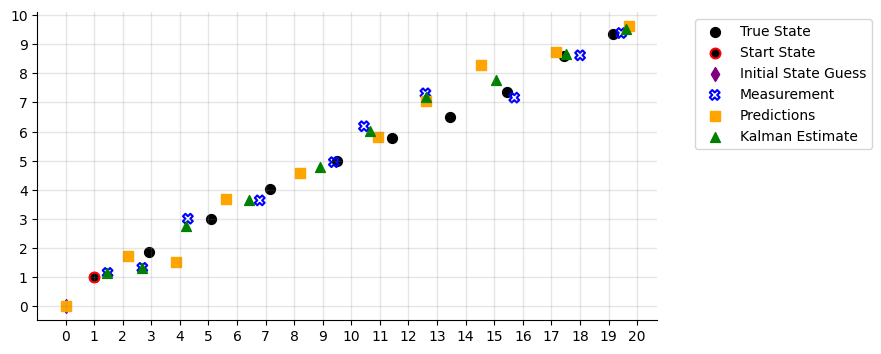

In [ ]:
### SIMULATE KALMAN FILTER PROCESS ###

# GLOBAL SETTINGS #
seed = 17
T = 10


# TRUE STATE GENERATION #
true_x0 = 1
true_vx0 = 2
true_y0 = 1
true_vy0 = 1
true_initial_state = np.array([[true_x0, true_vx0, true_y0, true_vy0]]).T
true_transition_matrix = np.array([
        [1, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
    ])
true_Q = 0.02 * np.array([
    [1, 0.25, 0.1, 0.05],
    [0.25, 0.1, 0.05, 0.05],
    [0.1, 0.05, 1, 0.25],
    [0.05, 0.05, 0.25, 0.1],
])
true_states = generate_true_states(
    true_initial_state = true_initial_state,
    true_transition_matrix = true_transition_matrix,
    true_Q = true_Q,
    T = T, seed = seed)


# MEASUREMENT GENERATION #
true_R = np.array([
    [2, 0],
    [0, 2]
])
H = np.array([
    [3.3, 0, 0, 0],
    [0, 0, 3.3, 0]
])
measurements = generate_measurement(
    true_states = true_states,
    true_R = true_R,
    H = H, seed = seed)


# KALMAN FILTER ESTIMATE #
delta_t = 1
# initial state vector estimate / guess
x = np.array([[0,0,0,0]]).T
P = np.array([
    [20, 0, 0, 0],
    [0, 20, 0, 0],
    [0, 0, 20, 0],
    [0, 0, 0, 20],
])

# transition function
F = np.array([
    [1, delta_t, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, delta_t],
    [0, 0, 0, 1],
])

# process noise
var_q = 0.005
Q = var_q * np.array([
    [0, 1, 0, 0],
    [1, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 1],
])

# measurement funxtion
H = np.array([
    [3.3, 0, 0, 0],
    [0, 0, 3.3, 0]
])

# measurement noise
R = np.array([
    [2, 0],
    [0, 2]
])

predictions, predictions_noise, kf_estimates = generate_kf_estimates(x, P, F, Q, H, R, measurements)

# VISUALIZATION #
scaled_measurements = measurements / 3.3
kalman_visualization(true_states = (true_states, 0, 2),
                     scaled_measurements = (scaled_measurements, 0, 1),
                     predictions = (predictions, 0, 2),
                     kf_estimates = (kf_estimates, 0, 2),
                     initial_state_guess = (x, 0, 2),
                     visualize=False,
                     true_states_toggle = True,
                     scaled_measurements_toggle = True,
                     kf_estimates_toggle = True,
                     initial_state_guess_toggle = True,
                     xticks_frequency=1, yticks_frequency=1);

# Kalman Filter Evaluation

We may have to iterate on the Kalman Filter (i.e., try different designs and matrix values). To compare across Kalman Filter implementations, we need metrics to define how well our Kalman Filter is working. In a simulated setting, where the true value is known, we can use the Normalized Estimated Error Squared.

## Normalized Estimated Error Squared

In contexts were we know the true values for state, such as in a simulation setting, we can use the normalized estimated error squared (NEES) as a metric to evaluate the model at a particular time step. The NEES, $𝜀_t$, is defined as:

$$
𝜀_t = (\mathbf{x}_t - \mathbf{\hat{x}}_t)^T\mathbf{P}^{-1}_t(\mathbf{x}_t - \mathbf{\hat{x}}_t)
$$

where:
- $\mathbf{x}_t$: the true state values at time $t$
- $\mathbf{\hat{x}}_t$: the estimated state values from the Kalman Filter at time $t$
- $\mathbf{\bar{P}}_t$: the state / prediction noise from the Kalman Filter at time $t$
